## Violations Search Tau

> Written by Jess Breda September 2023

For this notebook, I am working based on the to-dos from 2023-08-29 meeting and previous notebook `2023_08_violations_feature_analysis`/

The goals for this NB are

1. Update & test code to only apply exp filter to a session at a time

2. Update code to normalize all together before train test split. This might mean changing the order in generate_design_matrix. 
    * Or just a function that takes a list of dfs and finds the max value and normalize them by it?
    * Or just pass in the generated design matrix into train test split

3. Iterate over a finer grid of taus and sigmas

sigmas = 0.01, 0.1, 0.2, 0.5, 1, 1.5, 2, 2.5, 3, 5

taus = 1, 2, 3, 5, 10, 12, 15, 17, 20, 25, 30

In [49]:
import pathlib
import platform
import sys
[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_context("talk")

from sklearn.model_selection import train_test_split

from generate_design_matrix import *
from get_rat_data import *
from multiclass_logistic_regression import *
from method_validation import plot_kernel_validation

MODE = "local"

# settings
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Apply exp filter on session by session basis

In [121]:
# Example usage
df = pd.DataFrame(
    {
        "session": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
        "violation": np.random.randint(0, 2, 22),
    }
)
session_boundaries_mask = df["session"].diff() == 0

df["prev_violation"] = (df.violation.shift() * session_boundaries_mask).fillna(0)

tau = 1
filter_obj = ExpFilter(tau=tau, column="prev_violation")
filter_obj.apply_filter_to_dataframe(df)

Exp filter added for session 1 | Column: prev_violation, Tau: 1
Exp filter added for session 2 | Column: prev_violation, Tau: 1
Exp filter added for session 3 | Column: prev_violation, Tau: 1


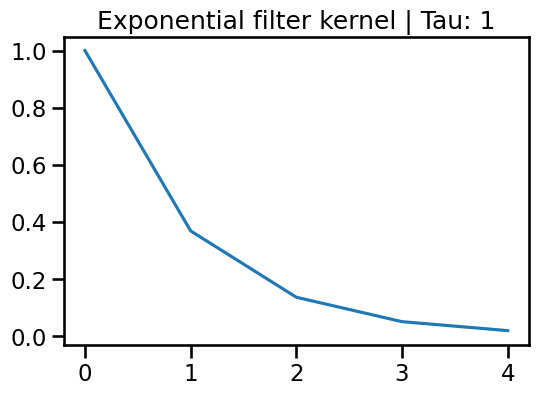

In [122]:
filter_obj.plot_kernel()

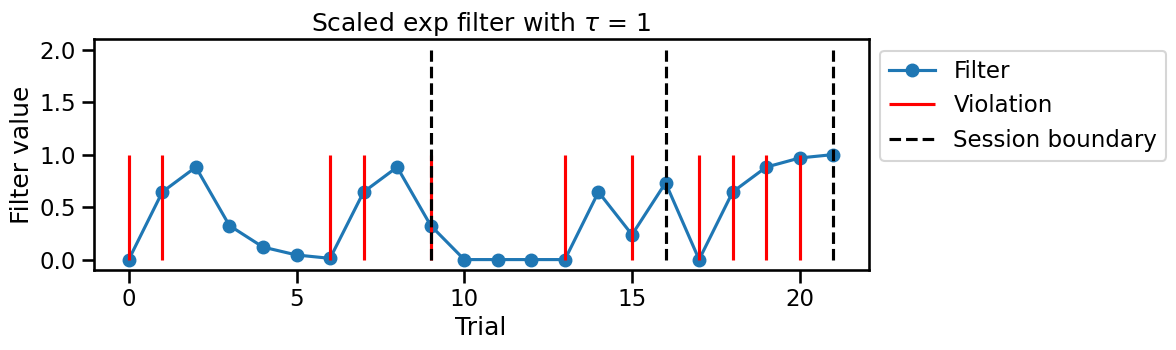

In [123]:
plot_kernel_validation(df, f"prev_violation_exp_{tau}")

TODO: 

[ ] put multiclasslogisitc regression into a .py

[ ] add .find_best_sigma()

[ ] add plot_best_fit_given_sigma( )
    - maybe find a way to add a sigma indicator in here?

[ ] add plot_feature_weights(animal_id, model_name)

[ ] make heat map

In [247]:
class MultiClassLogisticRegression:
    def __init__(self, sigma=None, method="BFGS", disp=True):
        self.W = None
        self.sigma = sigma
        self.method = method
        self.disp = disp
        self.stored_fits = []

    def fit(self, X: pd.DataFrame, Y: np.ndarray):
        N, D_w_bias = X.shape
        _, C = Y.shape
        initial_W_flat = np.zeros(D_w_bias * C)

        result = minimize(
            fun=self._cost,
            x0=initial_W_flat,
            args=(X.to_numpy(), Y, self.sigma),
            method=self.method,
            jac=self._gradient,
            options={"disp": self.disp},
        )

        self.W = result.x.reshape(D_w_bias, C)
        return self.W

    def eval(self, X: pd.DataFrame, Y: np.ndarray):
        return self._cost(self.W, X.to_numpy(), Y, sigma=0)

    def _cost(self, W, X, Y, sigma):
        """
        Compute the negative log-likelihood for multi-class
        logistic regression with L2 regularization (or MAP).

        params
        ------
        W : np.ndarray, shape (D + 1, C) or flattened (D+1 * C)
        weight matrix, will be in flattened form if in use
            for minimize() function
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with bias column
        Y : np.ndarray, shape (N, C), where C = 3
            one-hot encoded choice labels for each trial as left,
            right or violation
        sigma : float (default=None)
            standard deviation of Gaussian prior, if None no
            regularization is applied

        returns
        -------
        - nll : float
            negative log-likelihood
        """
        if len(W.shape) == 1:
            W = W.reshape(X.shape[1], Y.shape[1])

        logits = X @ W
        penalty = (
            1 / (2 * (sigma**2)) * np.trace(W[1:, :].T @ W[1:, :]) if sigma else 0
        )
        nll = (-np.sum(Y * logits) + np.sum(self._log_sum_exp(logits))) + penalty
        return nll

    def _gradient(self, W, X, Y, sigma):
        """
        Compute the gradient of the negative log-likelihood for
        multi-class logistic regression with L2 regularization (or MAP).

        params
        ------
        W : np.ndarray, shape (D + 1, C) or flattened (D+1 * C)
        weight matrix, will be in flattened form if in use
        for minimize() function
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with bias column
        Y : np.ndarray, shape (N, C), where C = 3
            one-hot encoded choice labels for each trial as left,
            right or violation
        sigma : float (default=None)
            standard deviation of Gaussian prior, if None no
            regularization is applied

        returns
        -------
        gradient :  np.ndarray, shape (D+1 * C)
            gradient of the negative log-likelihood

        """
        if len(W.shape) == 1:
            W = W.reshape(X.shape[1], Y.shape[1])

        logits = X @ W
        P = self._stable_softmax(logits)

        if sigma:
            penalty_gradient = W / (sigma**2)
        else:
            penalty_gradient = np.zeros_like(W)

        penalty_gradient[0, :] = 0  # No penalty for bias

        gradient = X.T @ (P - Y) + penalty_gradient
        return gradient.flatten()

    @staticmethod
    def _log_sum_exp(logits):
        max_logits = np.max(logits, axis=1, keepdims=True)
        return (
            np.log(np.sum(np.exp(logits - max_logits), axis=1, keepdims=True))
            + max_logits
        )

    @staticmethod
    def _stable_softmax(logits):
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        sum_exp = np.sum(exp_logits, axis=1, keepdims=True)
        return exp_logits / sum_exp

    def store(self, animal_id, model_name, nll, X):
        # Create a DataFrame for this iteration
        iter_df = pd.DataFrame(
            {
                "animal_id": [animal_id],
                "model_name": [model_name],
                "nll": [nll],
                "sigma": self.sigma,
                "features": [list(X.columns)],
                "weights": [list(self.W)],  # Convert numpy array to list
            }
        )
        # Append to the list of stored fits
        self.stored_fits.append(iter_df)

In [326]:
class SigmaTauSearchExperiment:
    def __init__(self, params):
        self.animals = params["animals"]
        self.sigmas = params["sigmas"]
        self.taus = params["taus"]
        self.model_names = self.generate_model_names(params)
        self.random_state = params["random_state"]
        self.test_size = params["test_size"]
        self.df = get_rat_viol_data(animal_ids=self.animals)
        self.stored_fits = []

    def run(self):
        for animal in self.animals:
            print(f"evaluating animal {animal}")
            if self.df.animal_id.nunique() > 1:
                # Load in data for specific animal
                animal_df = self.df.query("animal_id == @animal and training_stage > 2")
            else:
                animal_df = self.df.query("training_stage > 2")

            # Create a DesignMatrixGenerator object & get train/test sessions for animal
            dmg = DesignMatrixGenerator(verbose=False)
            dmg.get_train_test_sessions(
                animal_df, test_size=self.test_size, random_state=self.random_state
            )

            # Iterate over sigma/tau combinations
            for sigma in self.sigmas:
                for idx, tau in enumerate(self.taus):
                    # Generate design matrix & create train/test splits
                    X, Y = dmg.generate_design_matrix(
                        df, tau=tau, filter_column="prev_violation", return_labels=True
                    )
                    (
                        X_train,
                        X_test,
                        Y_train,
                        Y_test,
                    ) = dmg.apply_session_train_test_split(X, Y)

                    # Fit model & evaluate
                    model = MultiClassLogisticRegression(sigma=sigma)
                    W_fit = model.fit(X_train, Y_train)
                    nll = model.eval(X_test, Y_test)

                    # Store results
                    self.store(
                        animal, self.model_names[idx], nll, sigma, tau, X_test, W_fit
                    )

        self.results = pd.concat(self.stored_fits, ignore_index=True)
        return self.results

    def store(self, animal, model_name, nll, sigma, tau, X, W_fit):
        # Create a DataFrame for this iteration
        iter_df = pd.DataFrame(
            {
                "animal_id": [animal],
                "model_name": [model_name],
                "nll": [nll],
                "sigma": [sigma],
                "tau": [tau],
                "features": [list(X.columns)],
                "weights": [list(W_fit)],  # Convert numpy array to list
            }
        )
        # Append to the list of stored fits
        self.stored_fits.append(iter_df)

    @staticmethod
    def generate_model_names(params):
        taus = params["taus"]
        names = []

        for tau in taus:
            if tau is None:
                names.append("base")
            else:
                name = "t_" + str(tau)
                names.append(name)

        return names

In [320]:
params = {
    "animals": ["W065", "W078"],
    "sigmas": [0, 0.1],  # 0.3, 0.5],  # 0.7, 1, 1.5, 3, 5],
    "taus": [None, 1, 2, 10],  # 3, 5, 7, 9, 12, 15, 18, 20, 25, 30],
    "random_state": 44,
    "test_size": 0.25,
}

experiment = SigmaTauSearchExperiment(params)
results = experiment.run()

returning data for ['W065', 'W078']


In [325]:
results

,animal_id,model_name,nll,sigma,tau,features,weights
0,W065,base,18996.573042,0.0,None,"[bias, prev_violation, s_a, s_b, prev_sound_av...","[[0.26306710527160826, 0.2523659129143433, -0...."
1,W065,t_1,18794.357252,0.0,1,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.313863850738079, 0.316071824932679, -0.629..."
2,W065,t_2,18713.426680,0.0,2,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.35393049223232487, 0.3716070540769913, -0...."
3,W065,base,19001.210081,0.1,None,"[bias, prev_violation, s_a, s_b, prev_sound_av...","[[0.2603320473417563, 0.24972093584480182, -0...."
4,W065,t_1,18802.056226,0.1,1,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.30537744657405874, 0.30617940108112385, -0..."
5,W065,t_2,18725.347439,0.1,2,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.3370389859317092, 0.3503410285252892, -0.6..."
6,W078,base,17554.183410,0.0,None,"[bias, prev_violation, s_a, s_b, prev_sound_av...","[[0.26833318873997924, 0.2662067811535783, -0...."
7,W078,t_1,17395.817115,0.0,1,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.3165106787410056, 0.3282018603991755, -0.6..."
8,W078,t_2,17330.006916,0.0,2,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.353561697979342, 0.38188475748197187, -0.7..."
9,W078,base,17563.508781,0.1,None,"[bias, prev_violation, s_a, s_b, prev_sound_av...","[[0.2654621792619259, 0.2634584109326742, -0.5..."


In [329]:
def find_best_sigma(fitting_info_df):
    best_sigma_dfs = []
    for animal_id, sub_df in fitting_info_df.groupby(["animal_id"]):
        # Group by 'model_name' and find the row with minimum 'nll' for each group
        idx_best_sigma = sub_df.groupby("model_name")["nll"].idxmin()

        # Use these indices to find the corresponding best 'sigma' values
        best_sigma_df = sub_df.loc[idx_best_sigma][
            ["animal_id", "model_name", "sigma", "nll"]
        ]

        # Append the DataFrame to the list
        best_sigma_dfs.append(best_sigma_df)

    # Concatenate all the DataFrames in the list
    best_sigma_df = pd.concat(best_sigma_dfs, ignore_index=True)
    return best_sigma_df


best_sigma_df = find_best_sigma(results)


def plot_best_fit(best_sigma_df):
    n_animals = best_sigma_df.animal_id.nunique()
    fig, ax = plt.subplots(
        n_animals, 1, figsize=(15, 5 * n_animals), sharex=True, sharey=True
    )

    if n_animals == 1:
        ax = [ax]
        sns.pointplot(
            x="model_name",
            y="nll",
            data=best_sigma_df,
            ax=ax,
            order=experiment.model_names,
        )
        plt.xticks(rotation=90)

        ax.set(
            ylabel="Test Negative Log Likelihood",
            xlabel="Model",
            title=f"Animal {best_sigma_df.animal_id.unique()[0]}",
        )
    else:
        for idx, (animal_id, sub_df) in enumerate(best_sigma_df.groupby("animal_id")):
            sns.pointplot(
                x="model_name",
                y="nll",
                data=sub_df,
                ax=ax[idx],
                order=experiment.model_names,
            )
            ax[idx].set(
                title=f"Animal {animal_id}",
                ylabel="Test Negative Log Likelihood",
                xlabel="",
            )
            plt.xticks(rotation=90)

            # if on the last plot, add the x-axis label
            if idx == n_animals - 1:
                ax[idx].set(xlabel="Model")

    sns.despine()

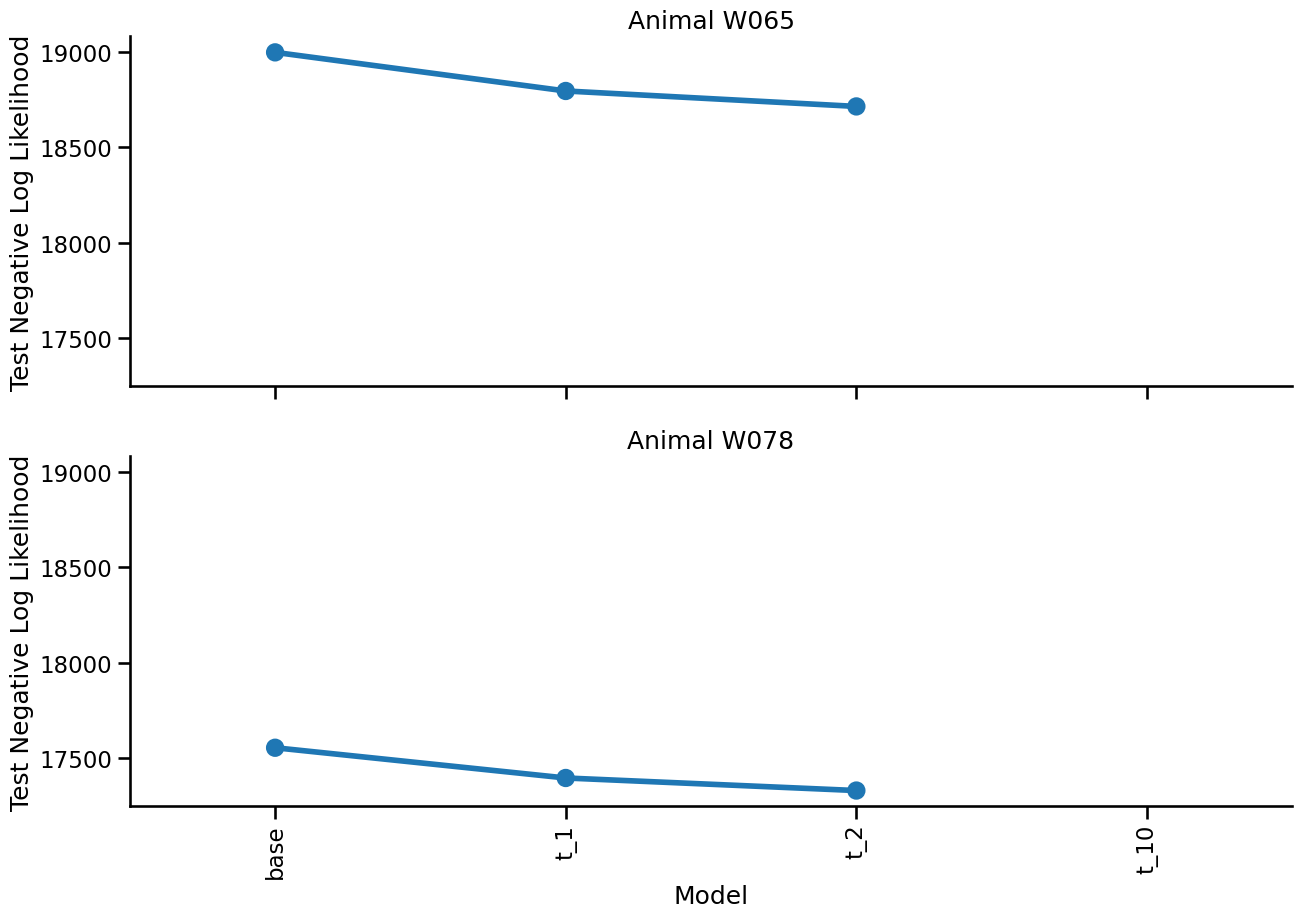

In [330]:
plot_best_fit(best_sigma_df)

In [227]:
best_sigma_df

,animal_id,model_name,sigma,nll
0,W065,base,0.0,19473.118958
1,W065,t_1,0.0,19290.987707
2,W065,t_2,0.0,19222.315723
3,W065,t_3,0.0,19235.428731
4,W065,t_5,0.0,19302.856038
5,W078,base,0.1,17967.888720
6,W078,t_1,0.3,17797.312022
7,W078,t_2,0.3,17737.394355
8,W078,t_3,0.3,17753.701434
9,W078,t_5,0.3,17820.944286


In [228]:
def plot_class_weights(feature_names, W_fit, title=""):
    """
    Plot the weights for each feature and class as bar charts.

    Parameters:
    feature_names: list (D)
         column names from design matrix that related
         to features in W_fit
    W_fit : np.ndarray (D x C)
        weights obtained after optimization (D x C)
    title : str (default: "")
        title for the plot
    """

    # Extract shape details
    D, C = W_fit.shape
    classes = ["L", "R", "V"]

    # Prepare data for Seaborn
    weight_data = []
    for c in range(C):
        for d in range(D):
            weight_data.append(
                {
                    "Weight": W_fit[d, c],
                    "Feature": feature_names[d],
                    "Class": classes[c],
                }
            )

    df_weights = pd.DataFrame(weight_data)

    # Plot using Seaborn
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.axhline(y=0, color="black")
    sns.barplot(x="Feature", y="Weight", hue="Class", data=df_weights, ax=ax)
    plt.xticks(rotation=90)
    plt.legend(loc="upper left")
    plt.title(title)

    return None


def plot_class_weights_from_df(fitting_info_df, model_name):
    row = fitting_info_df.loc[fitting_info_df["model_name"] == model_name].iloc[0]
    features = row["features"]
    weights = np.array(row["weights"])
    plot_class_weights(features, weights, title=model_name)

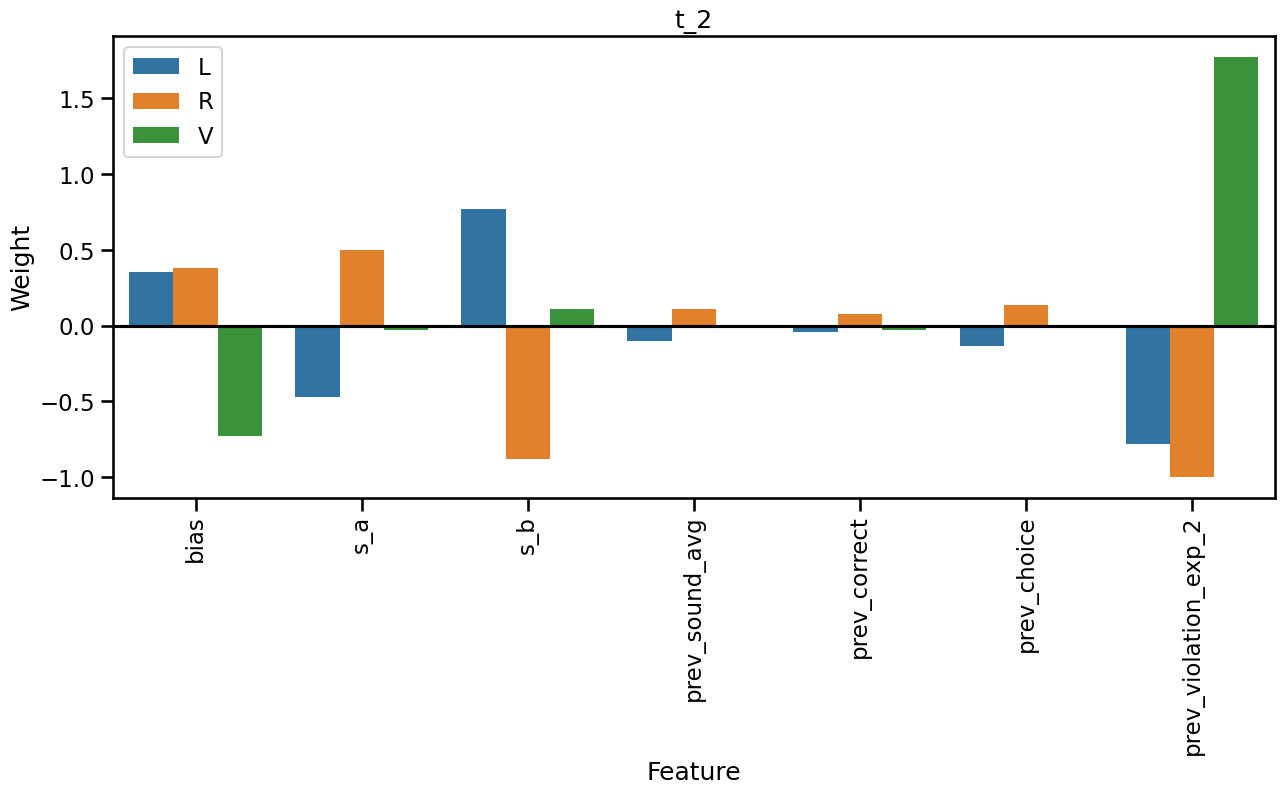

In [237]:
plot_class_weights_from_df(fitting_info_df, "t_2")

Could think about putting some of the plotting functions above into a separate file. 

Also could involve some polishing where FitMutliClassLR class could be made with .fit, .eval, .store .plot(?) functions. 
